In [1]:
import pandas as pd

In [2]:
dataTr=pd.read_csv("D:\cse465_Pro\Train.csv")

In [3]:
dataTr.head()

,Data,Label
0,মুগ্ধ হয়ে গেলাম মামু. আর তোমায় কি কমু. বলো তোম...,1
1,এই কুত্তার বাচ্চাদের জন্য দেশটা আজ এমন অবস্তায়...,2
2,ভাই আপনার কথাই যাদু রয়েছে,1
3,উওরটা আমার অনেক ভাল লেগেছে,1
4,আমার নিজের গাড়ী নিয়ে কি সাজেক যেতে পারবো না ?...,0


In [4]:
dataTr.isnull().sum()

Data     0
Label    0
dtype: int64

In [5]:
dataTe=pd.read_csv("D:\cse465_Pro\Test.csv")

In [6]:
dataTe.head()

,Data,Label
0,"স্বাস্থ্যবান হতে চাই , আমি বয়সের তুলনায় অনেক ব...",0
1,ভাইয়া নতুন ভিডিও আসে না কেন,0
2,সৌরভ গাঙ্গুলী ছাড়া দাদাগিরি কখনো জমে উঠত না,0
3,ক্রিকেট কে বাচাতে হলে পাপকে অতিশিগ্রিই তাকেও গ...,2
4,আমিতো সেই ঝালপ্রিয়ো মানুষ,1


In [7]:
dataTe.isnull().sum()

Data     0
Label    0
dtype: int64

In [8]:
dataV=pd.read_csv("D:\cse465_Pro\Val.csv")

In [9]:
dataV.head()

,Data,Label
0,আর আমার খুবেই আনন্দ লাকছে ভাইটি চাকরি পেয়েছে,1
1,ভাই আমাদের আগের মেয়র আনিচুল হক নাই যে আমাদের ক...,2
2,আমি মার্ক ওয়েন আর সনির বিশাল ভক্ত । একটা সময় ভ...,1
3,৩ মাস না যেতেই একেকজন ফুলে ফেপে আলুর দম,2
4,"বাংলাদেশের পুলিশ হলো নিরীহ মানুষের যম , আর অত্...",2


In [10]:
dataV.isnull().sum()

Data     0
Label    0
dtype: int64

In [11]:
x = dataTr['Data']
Y = dataTr['Label']

In [14]:
dataTr.shape

(12575, 2)

In [12]:
Y.value_counts()

Label
1    5133
2    4548
0    2894
Name: count, dtype: int64

In [13]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
Y_encoder = label.fit_transform(Y)

In [18]:
from datasets import Dataset
data_hugging_face = Dataset.from_pandas(pd.DataFrame({'text': x, 'label': Y_encoder}))
data_hugging_face = data_hugging_face.train_test_split(test_size=0.2, seed=42)

c:\Users\User\anaconda3\envs\llm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
model_name = 'distilbert-base-uncased'

In [20]:
from transformers import DistilBertTokenizer, DistilBertModel

In [21]:
from transformers import AutoTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [22]:
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

In [23]:

from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label.classes_))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

data_hugging_face = data_hugging_face.map(tokenize_function, batched=True)
data_hugging_face = data_hugging_face.remove_columns(['text'])
data_hugging_face = data_hugging_face.rename_column('label', 'labels')
data_hugging_face.set_format('torch')

Map: 100%|██████████| 2515/2515 [00:01<00:00, 1324.94 examples/s]


In [15]:
from sklearn.metrics import accuracy_score, f1_score

In [31]:
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=1,
    save_strategy='no',
    load_best_model_at_end=False,
    report_to=[]
)

In [14]:
import numpy as np

In [37]:
from transformers import Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data_hugging_face['train'],
    eval_dataset=data_hugging_face['test'],
    tokenizer=tokenizer,
    compute_metrics=lambda eval_pred: {
        "accuracy": accuracy_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1)),
        "f1": f1_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), average="weighted")
    }
)

C:\Users\User\AppData\Local\Temp\ipykernel_2488\2826380701.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [38]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.385900,1.172509,0.590457,0.585515
2,1.051900,0.870679,0.633797,0.619024
3,1.292900,0.869744,0.637376,0.633409
4,0.421200,0.895355,0.633400,0.631328
5,0.469100,0.933770,0.635388,0.636228


TrainOutput(global_step=6290, training_loss=0.6927360658171114, metrics={'train_runtime': 1820.893, 'train_samples_per_second': 27.624, 'train_steps_per_second': 3.454, 'total_flos': 6663228979507200.0, 'train_loss': 0.6927360658171114, 'epoch': 5.0})

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
from sklearn.metrics import classification_report , confusion_matrix

Evaluation results: {'eval_loss': 0.9337698221206665, 'eval_accuracy': 0.6353876739562624, 'eval_f1': 0.6362276304931023, 'eval_runtime': 25.8837, 'eval_samples_per_second': 97.165, 'eval_steps_per_second': 12.17, 'epoch': 5.0}
Classification Report:
               precision    recall  f1-score   support

     Neutral       0.44      0.45      0.44       568
    Negative       0.71      0.68      0.70      1031
    Positive       0.68      0.70      0.69       916

    accuracy                           0.64      2515
   macro avg       0.61      0.61      0.61      2515
weighted avg       0.64      0.64      0.64      2515



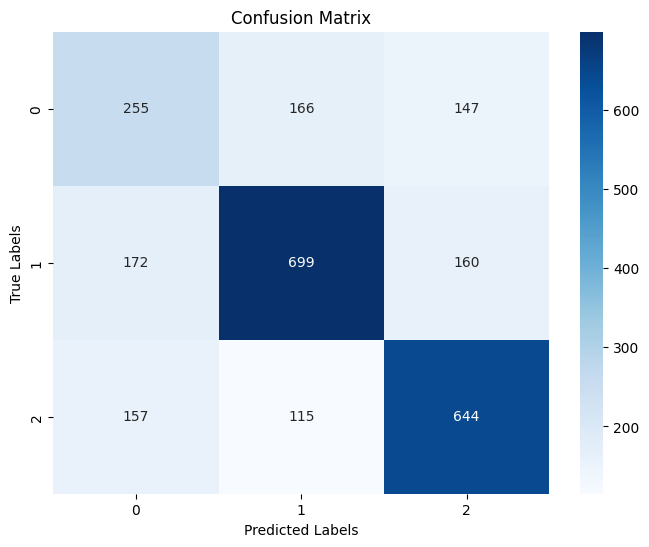

In [45]:
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")
# Generate predictions
predictions_output = trainer.predict(data_hugging_face['test'])
predictions = np.argmax(predictions_output.predictions, axis=1)
labels = predictions_output.label_ids

# Classification report
t_names = ['Neutral','Negative', 'Positive']
report = classification_report(labels, predictions, target_names=t_names )
print("Classification Report:\n", report)
     



# Confusion matrix
conf_matrix = confusion_matrix(labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [46]:
trainer.save_model('Distil_Bert_Tr')

In [18]:
from datasets import Dataset, DatasetDict

c:\Users\User\anaconda3\envs\llm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
import torch

In [20]:
from transformers import TrainingArguments,Trainer

In [33]:

# Rename labels
label_mapping = {0: "Neutral", 1: "Positive", 2: "Negative"}
dataTr["Label"] = dataTr["Label"].map(label_mapping)
dataTe["Label"] = dataTe["Label"].map(label_mapping)
dataV["Label"] = dataV["Label"].map(label_mapping)

# Check for missing values and shuffle
def preprocess_df(df):
    df.dropna(inplace=True)
    return df.sample(frac=1, random_state=42).reset_index(drop=True)

train_df = preprocess_df(dataTr)
test_df = preprocess_df(dataTe)
val_df = preprocess_df(dataV)

# Convert to Hugging Face dataset
def convert_to_dataset(df):
    return Dataset.from_pandas(pd.DataFrame({'text': df['Data'], 'label': df['Label']}))

dataset = DatasetDict({
    "train": convert_to_dataset(train_df),
    "validation": convert_to_dataset(val_df),
    "test": convert_to_dataset(test_df)
})

# Encode labels
label_list = ["Neutral", "Positive", "Negative"]
label_to_id = {label: i for i, label in enumerate(label_list)}

dataset = dataset.map(lambda x: {"label": [label_to_id[label] for label in x["label"]]}, batched=True)

# Load model and tokenizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'distilbert-base-uncased'
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_list)).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.remove_columns(['text']).rename_column('label', 'labels')
dataset.set_format('torch')

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=8,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy='epoch',
    load_best_model_at_end=True,
    report_to=[],
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    save_total_limit=3
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=lambda eval_pred: {
        "accuracy": accuracy_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1)),
        "f1": f1_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), average="weighted")
    },
   
)

# Train model
trainer.train()

# Evaluate model on validation set
val_results = trainer.evaluate()
print("Validation Results:", val_results)

# Final evaluation on test set
test_output = trainer.predict(dataset["test"])
test_predictions = np.argmax(test_output.predictions, axis=1)
test_labels = test_output.label_ids

# Classification report
report = classification_report(test_labels, test_predictions, target_names=label_list)
print("Test Set Classification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\User\anaconda3\envs\llm\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\User\AppData\Local\Temp\ipykernel_13952\2346720786.py:66: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


ValueError: num_samples should be a positive integer value, but got num_samples=0

Map: 100%|██████████| 1586/1586 [00:00<00:00, 27708.35 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 1586/1586 [00:00<00:00, 5660.28 examples/s]
c:\Users\User\anaconda3\envs\llm\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\User\AppData\Local\Temp\ipykernel_10860\65253249.py:106: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.044400,0.892746,0.585195,0.560549
2,0.894800,0.856579,0.616465,0.594899
3,0.858400,0.820904,0.635609,0.626875
4,0.649100,0.833711,0.646458,0.650636
5,0.736400,0.826414,0.655392,0.649073
6,0.564600,0.832685,0.661774,0.663804
7,0.500500,0.881443,0.669432,0.671035
8,0.450100,0.907229,0.669432,0.668739


Validation Results: {'eval_loss': 0.8209040760993958, 'eval_accuracy': 0.635609444798979, 'eval_f1': 0.6268751200650287, 'eval_runtime': 16.0691, 'eval_samples_per_second': 97.517, 'eval_steps_per_second': 12.197, 'epoch': 8.0}
Test Set Classification Report:
               precision    recall  f1-score   support

     Neutral       0.42      0.35      0.38       361
    Positive       0.72      0.61      0.66       654
    Negative       0.60      0.77      0.68       571

    accuracy                           0.61      1586
   macro avg       0.58      0.58      0.57      1586
weighted avg       0.61      0.61      0.60      1586



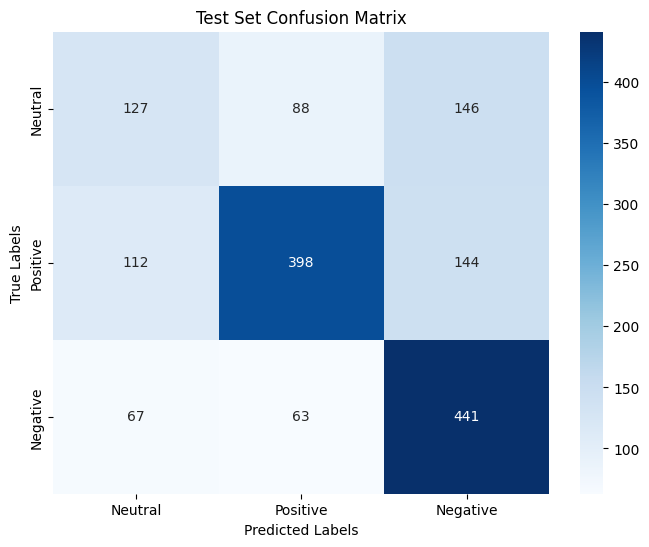

In [21]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset, DatasetDict
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Rename labels
label_mapping = {0: "Neutral", 1: "Positive", 2: "Negative"}
dataTr["Label"] = dataTr["Label"].map(label_mapping)
dataTe["Label"] = dataTe["Label"].map(label_mapping)
dataV["Label"] = dataV["Label"].map(label_mapping)

# Check for missing values and shuffle
def preprocess_df(df):
    df = df.dropna().sample(frac=1, random_state=42).reset_index(drop=True)
    if df.empty:
        raise ValueError("Error: Processed dataframe is empty! Check your dataset loading and preprocessing.")
    return df

try:
    train_df = preprocess_df(dataTr)
    test_df = preprocess_df(dataTe)
    val_df = preprocess_df(dataV)
except ValueError as e:
    print(e)
    exit()

# Convert to Hugging Face dataset
def convert_to_dataset(df):
    if df.empty:
        raise ValueError("Dataset conversion failed: The dataframe is empty.")
    return Dataset.from_pandas(pd.DataFrame({'text': df['Data'], 'label': df['Label']}))

try:
    dataset = DatasetDict({
        "train": convert_to_dataset(train_df),
        "validation": convert_to_dataset(val_df),
        "test": convert_to_dataset(test_df)
    })
except ValueError as e:
    print(e)
    exit()

# Encode labels
label_list = ["Neutral", "Positive", "Negative"]
label_to_id = {label: i for i, label in enumerate(label_list)}

# Ensure labels are mapped correctly
def encode_labels(example):
    if example["label"] not in label_to_id:
        raise ValueError(f"Unexpected label value: {example['label']}")
    return {"label": label_to_id[example["label"]]}

dataset = dataset.map(encode_labels)

# Load model and tokenizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'distilbert-base-uncased'
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_list)).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.remove_columns(['text']).rename_column('label', 'labels')
dataset.set_format('torch')

# Check if dataset is empty
for split in ["train", "validation", "test"]:
    if len(dataset[split]) == 0:
        raise ValueError(f"Dataset split '{split}' is empty after preprocessing. Please check your input data.")

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,  # Reduced batch size to prevent issues with small datasets
    per_device_eval_batch_size=8,
    num_train_epochs=8,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy='epoch',
    load_best_model_at_end=True,
    report_to=[],
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    save_total_limit=3
)

# Trainer setup
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train model
trainer.train()

# Evaluate model on validation set
val_results = trainer.evaluate()
print("Validation Results:", val_results)

# Final evaluation on test set
test_output = trainer.predict(dataset["test"])
test_predictions = np.argmax(test_output.predictions, axis=1)
test_labels = test_output.label_ids

# Classification report
report = classification_report(test_labels, test_predictions, target_names=label_list)
print("Test Set Classification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [22]:
trainer.save_model('Distil_Bert_Final')